In [6]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np
import pickle

Using TensorFlow backend.


In [1]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 40

In [2]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
    hand_name = ['left', 'right']
    
    fingertip_pos = np.zeros([2, 5, 3])
    
    hand_palm_pos = np.zeros([2, 3])
    hand_palm_rpy = np.zeros([2, 3])
    hand_palm_unit_vector = np.zeros([2, 3])
    arm_direction = np.zeros([2, 3])
    index_finger_vector = np.zeros([2, 3])
    
    feature = np.zeros([dimensions])
    
    for hand_idx, hand in enumerate(hand_name):
        if not hand in frame['hands']:
            continue
        hand_palm_pos[hand_idx] = np.array(frame['hands'][hand]['hand_palm_position'])
        hand_palm_rpy[hand_idx] = np.array([ frame['hands'][hand]['roll'],
                                                    frame['hands'][hand]['pitch'],
                                                    frame['hands'][hand]['yaw']])
        hand_palm_unit_vector[hand_idx] = np.cross(
            frame['hands'][hand]['fingers']['index']['bones']['proximal']['direction'],
            frame['hands'][hand]['fingers']['middle']['bones']['proximal']['direction']
        )
        arm_direction[hand_idx] = np.array(frame['hands'][hand]['arm']['direction'])
        index_finger_vector[hand_idx] = np.array(frame['hands'][hand]['fingers']['index']['bones']['distal']['direction'])
        
        for finger_idx, finger in enumerate(finger_name):
            fingertip_pos[hand_idx, finger_idx] = (
                np.array(frame['hands'][hand]['fingers'][finger]['bones']['distal']['next_joint'])
            )
            
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    dist_btw_fingertip = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2)
        
    feature[0:6] = hand_palm_pos.reshape(6)
    feature[6:12] = hand_palm_rpy.reshape(6)
    feature[12:22] = dist_btw_fingertip.reshape(10)
    feature[22:28] = hand_palm_unit_vector.reshape(6)
    feature[28:34] = arm_direction.reshape(6)
    feature[34:40] = index_finger_vector.reshape(6)
    
    return feature
    

In [3]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
        feature = get_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [4]:
def get_augmentation(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [8]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [9]:
speedup = 10
pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)

In [10]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
        _timesteps = get_augmentation(+10, _timesteps, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)

In [11]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [12]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [13]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [14]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [15]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
print(x_train_shuffle.shape, Y_train_shuffle.shape, x_test.shape, Y_test.shape)

(684, 50, 40) (684, 19) (342, 50, 40) (342, 19)


In [32]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 2s 3ms/step - loss: 0.6981 - acc: 0.7485 - val_loss: 0.4066 - val_acc: 0.8567
Epoch 2/1000
224/684 [========>.....................] - ETA: 1s - loss: 0.7439 - acc: 0.7455

KeyboardInterrupt: 

In [17]:
model.save("./history/model0804201802.h5")
with open('./history/history0804201802.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [31]:
model = load_model("./history/model0804201802.h5")
with open('./history/history0804201802.pkl', 'rb') as handle:
    load_history = pickle.load(handle)

In [18]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 255us/step
Test score: 0.40738505491
Test accuracy: 0.856725146199


In [19]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


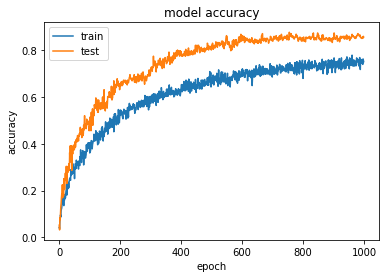

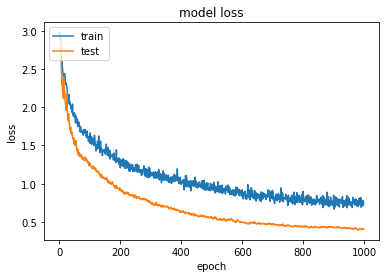

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction section

In [41]:
x_predict = np.zeros([0, timesteps, dimensions])
y_actual = np.zeros([0])

test_data_per_word = 10

for word_no, word in enumerate(words):
    for data_no in range(test_data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)

        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        _timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x_predict = np.vstack((x_predict, [_timesteps]))
        y_actual = np.append(y_actual, word_no)
        
x_predict_norm = (x_predict-x_mean)/x_std
    
prediction = model.predict(x_predict_norm, verbose = 1)

190/190 [==============================] - 0s 880us/step


In [21]:
y_actual = y_test
test_data_per_word = 18
prediction = model.predict(x_test, verbose = 1)

342/342 [==============================] - 0s 398us/step


In [22]:
confusion_matrix = np.zeros([len(words), len(words)])
prediction_word_index = np.argmax(prediction, axis = 1)

for idx in range(len(prediction_word_index)):
    actual = y_actual[idx]
    result = prediction_word_index[idx]
    confusion_matrix[int(actual)][result] += 1

In [23]:
test_acc = 0

for idx in range(len(words)):
    test_acc += confusion_matrix[idx][idx]
test_acc /= (test_data_per_word * len(words))

print(test_acc)


0.856725146199


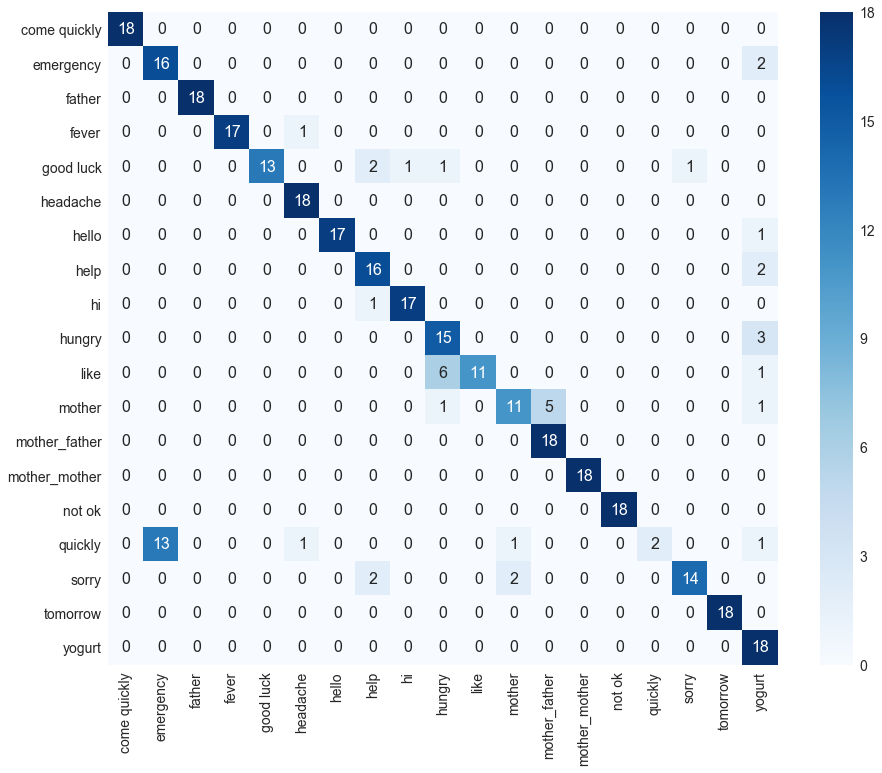

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
   
df_cm = pd.DataFrame(confusion_matrix, words, words)
plt.figure(figsize = (15,12))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16})# font size